# Functional Feynman-Kac Formula [Dupire (2009)]

Let $x$ be a process given by the SDE 
$$dx_s = \mu(X_s) ds + \sigma(X_s) dw_x.$$

Consider functionals $g :\Lambda_T \longrightarrow R$, $\lambda: \Lambda \longrightarrow R$ and $k:\Lambda \longrightarrow R$ and define the functional $f$ as
$$f(Y_t) = E\left[\left.e^{-\int_t^T \lambda(X_u) du} g(X_T) + \int_t^T e^{-\int_t^s \lambda(X_u) du} k(X_s) ds \ \right| \ Y_t \right],$$
for any path $Y_t \in \Lambda$, $t \in [0,T]$ Thus, if $f \in C^{1,2}$ and $k$, $\lambda$, $\mu$ and $\sigma$ are $\Lambda$-continuous, then $f$ satisfies the Path-dependent Partial Differential Equation (PPDE):
\begin{align}\label{eq:feynman-kac-equation}
\Delta_t f(Y_t) + \mu(Y_t) \Delta_x f(Y_t)  + \frac{1}{2} \sigma^2(Y_t) \Delta_{xx} f(Y_t) - \lambda(Y_t)f(Y_t) + k(Y_t) = 0,
\end{align}
with $f(Y_T) = g(Y_T)$, for any $Y_t$ in the topological support of $x$.



# Geometric Asian Option

Under Black--Scholes setting, where the spot value follows a Geometric Brownian Motion with constant parameters
$$dx_t = (r - q)x_tdt + \sigma x_t dw_t.$$

Under this model, the price of a geometric Asian optin with maturity $T$ and payoff $g: \Lambda_T \longrightarrow R$ solves the PPDE
\begin{align}\label{eqn:PPDE_BS}
\begin{cases}
\Delta_t f(Y_t) + (r - q) y_t \Delta_x f(Y_t) + \displaystyle \frac{1}{2}\sigma^2 y_t^2 \Delta_{xx} f(Y_t) - r f(Y_t) = 0,\\[10pt]
f(Y_T) = g(Y_T) = \left(\exp\left\{\frac{1}{T} \int_0^T \log y_t dt \right\} - K\right)^+.
\end{cases}
\end{align}

# Our Method

Approximate $f(X_t)$ using a combination of LSTM network and a feedforward NN, and use finite difference to find gradients. See detail in paper.

In [1]:
"""
    Python 3.5
    Keras 2.2.2
    Tensorflow 1.10.0
"""
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm
import tensorflow as tf
import time as ttt

import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Dense, Activation,LSTM
from keras.optimizers import Adam
from keras.regularizers import L1L2



Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True                           
sess = tf.InteractiveSession(config=config)
set_session(sess)  # set TensorFlow session as the default session for Keras

In [3]:
M = 128 # number of samples in a batch
T = 1 # terminal time
dt = 0.01 # detla_t = 0.01, 0.005, 0.002, 0.001
steps = int(T/dt) # number of time steps
r = 0.03
q = 0.01 
sigma = 1
x_0 = 1.0 # X_0 
Strike = 0.4 #Strike Price

In [4]:
def generate_t(T, steps, M = M):
    '''
    time discretization (M * (steps+1 +1)) 
    for computing the time derivative, we need an extra time step.
    '''
    t_temp = np.linspace(1e-6, T- 1e-6, steps +1, dtype = np.float32)
    return np.tile(np.concatenate((t_temp, [T + dt])), (M,1)) # extra after terminal

In [5]:
# for example
t = generate_t(T, steps)[0][0:-1]
print("the length of t is {}".format(len(t)+1))

the length of t is 102


In [6]:
def Create_paths(i, M):
    '''
    GBM paths (M * (steps+1)) with seed i
    number of steps could be 100, 200, 500, 1000.
    '''
    
    # generate time steps for each path
    np.random.seed(i)
    x = np.tile(x_0, (M, 1))
    path = np.tile(x_0, (M, 1))
    delta = T/1000
    
    dW = np.sqrt(delta)*np.random.normal(size=(M, 1000))
    for k in range(1000):
        x += (r-q) * x * delta + sigma * x * dW[:,k:k+1]
        path = np.concatenate((path, x), axis = 1)
        
    #  select # of steps (100, 200, 500, 1000) from total 1000 timesteps
    selection = np.linspace(0,1000, steps+1, dtype = np.int) 
    path = np.array(path, dtype=np.float32)
    path_selection = path[:,selection]

    return np.array(path_selection, dtype=np.float32)

Text(0.5, 0, 'Time')

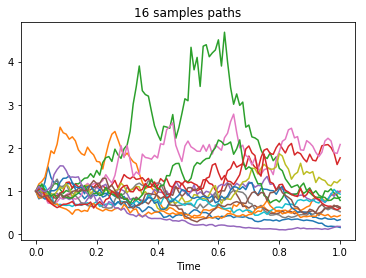

In [7]:
for i in range(16):
    plt.plot(t, Create_paths(100000000, M)[i])
plt.title("16 samples paths")
plt.xlabel("Time")

In [8]:
# input time and path as placeholders
path = tf.placeholder(dtype=tf.float32, shape=[M,steps+1])
time = tf.placeholder(dtype = tf.float32, shape = [M, steps +1 + 1]) # extra after T

## True Solution and Terminal Condition

 A closed-form solution is available in this case:
$$f(Y_t) = e^{-r(T-t)} \left(G_t^{t/T}y_t^{1 - t/T} e^{\bar{\mu} + \bar{\sigma}^2/2} \Phi(d_1) - K\Phi(d_2) \right),$$
where $\Phi$ is the cumulative distribution function of the standard normal,
\begin{align}
G_t &= \exp\left\{\frac{1}{t} \int_0^t \log y_u du \right\}\\
\bar{\mu} &= \left(r - q - \frac{\sigma^2}{2}\right)\frac{1}{2T}(T-t)^2,\\
\bar{\sigma} &= \frac{\sigma}{T} \sqrt{\frac{1}{3}(T-t)^3},\\
d_2 &= \frac{(t/T) \log G_t + \left(1 - t/T\right) \log y_t + \bar{\mu} - \log K}{\bar{\sigma}},\\
d_1 &= d_2 + \bar{\sigma}.
\end{align}
In the numerical examples below, we fix the strike price to $K = 0.4$. 

In [9]:
def true_solution(apath):
    '''
    Givin a path, it outputs the true solution.
    '''
    G = 1
    mu_bar = (r-q-sigma**2/2)/2/T * (T-t[0])**2
    sigma_bar = sigma/T * np.sqrt(1/3*(T-t[0])**3)
    d_2 = 1/sigma_bar * (t[0]/T * np.log(G) + (1 - t[0]/T) * np.log(apath[0]) + mu_bar - np.log(Strike))
    d_1 = d_2 + sigma_bar
    true_solution = [np.exp(-r*(T - t[0])) * ( G**(t[0]/T) * (apath[0] **(1-t[0]/T)) * np.exp(mu_bar + sigma_bar**2/2) * norm.cdf(d_1) 
                    - Strike * norm.cdf(d_2))]
    
    for k in range(1, steps+1):
        G = np.exp(1/t[k] * np.sum((np.log(apath[1:k+1]) + np.log(apath[:k]) )/2)*dt)
        mu_bar = (r-q-sigma**2/2)/2/T * (T-t[k])**2
        sigma_bar = sigma/T * np.sqrt(1/3*(T-t[k])**3)
        d_2 = 1/sigma_bar * (t[k]/T * np.log(G) + (1 - t[k]/T) * np.log(apath[k]) + mu_bar - np.log(Strike))
        d_1 = d_2 + sigma_bar
        true_solution.append(np.exp(-r*(T - t[k])) * (G**(t[k]/T) * (apath[k] **(1-t[k]/T)) * np.exp(mu_bar + sigma_bar**2/2) * norm.cdf(d_1) 
                        - Strike * norm.cdf(d_2)))

    return true_solution

In [10]:
def terminal_condition(apath):
    '''
    Givin a path, it outputs the terminal condition g(Y_T).
    '''
    
    return np.maximum(np.exp(1/T*sum( (np.log(apath[1:]) + np.log(apath[:-1]) )/2)*dt) - Strike,0)

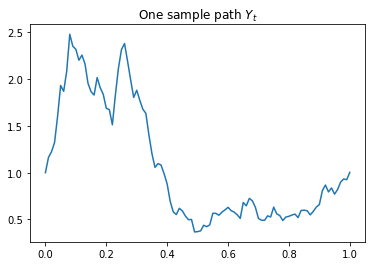

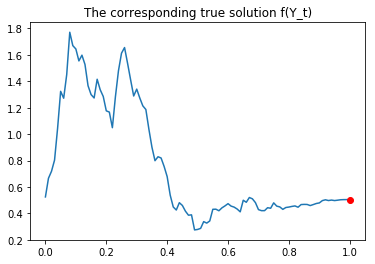

In [11]:
# for example given a GBM path
path1 = Create_paths(100000000, M)[1]
plt.plot(t, path1)
plt.title("One sample path $Y_t$")
plt.show()

plt.plot(t, true_solution(path1))
plt.plot(T, terminal_condition(path1), "ro")
plt.title("The corresponding true solution f(Y_t)")
plt.show()

## Neural Network Setup

The path-dependent function $f(X_t)$ is been approximated by a combination of LSTM and a feedforward neural network.

In [12]:
n_a = 128 # number of hidden neurons in the LSTM network
LSTM_cell = LSTM(n_a, return_state = True) # This is used to capture the long term dependency

# This feedforward neural network is used to compute the derivatives.
# input dimension is (1+1+n_a) = (space, time, path (which is characterized by n_a hidden neurons))
NN = Sequential([
    Dense(128, input_shape=(1+1+n_a,)),
    Activation('tanh'),
    Dense(128),
    Activation('tanh'),
    Dense(128),
    Activation('tanh'),
    Dense(1)
])

## Objective Function

\begin{align}\label{eq:loss_NM}
J_{N,M}(\theta) = \frac{1}{M} \frac{1}{N}\sum_{j=1}^M \sum_{i=0}^N \left(\Delta_{t} u(Y^{(j)}_{t_i};\theta) + L u(Y^{(j)}_{t_i};\theta)\right)^2 +  \frac{1}{M}\sum_{j=1}^M \left(u(Y^{(j)}_{t_N}; \theta) - g(Y_{t_N}^{(j)}) \right)^2.
\end{align}

In [13]:
def loss_function(time,path, M):
    
    a = tf.Variable(tf.zeros([M, n_a]), trainable=False)
    c = tf.Variable(tf.zeros([M, n_a]), trainable=False)

##. Approximate f(X_{t_0})
    input_x = K.slice(path, [0,0], [M,1])
    input_t = K.slice(time, [0,0], [M,1])
    inputt_f = K.concatenate([input_x, input_t, a])
    f = NN(inputt_f)
                      
##.   calculate space derivatives
    bump = 0.01 * input_x
    input_x_up = input_x + bump
    inputt_up = K.concatenate([input_x_up, input_t, a])
    f_up = NN(inputt_up)
    input_x_down = input_x - bump
    inputt_down = K.concatenate([input_x_down, input_t, a])
    f_down = NN(inputt_down)
    partial_x_f = (f_up - f)/bump
    partial_xx_f = (f_up - 2*f + f_down)/bump/bump

##. Next LSTM cell
    input_x_reshape = tf.reshape(input_x, (M,1,1))
    input_t_reshape = tf.reshape(input_t, (M,1,1))
    inputt = K.concatenate([input_x_reshape, input_t_reshape])
    a, _, c = LSTM_cell(inputt, initial_state = [a, c])
    
##.   calculate time derivative
    input_t_time = K.slice(time, [0, 1], [M, 1])
    inputt_time = K.concatenate([input_x, input_t_time, a])
    f_flat = NN(inputt_time)
    partial_t_f = (f_flat - f)/dt
    
    Loss = tf.reduce_sum(tf.square(partial_t_f + (r-q)*input_x * partial_x_f + 0.5 * sigma**2 * input_x **2 * partial_xx_f - r * f)) 

    solution = f
    time_derivative = partial_t_f 
    space_derivative = partial_x_f
    space_2nd_derivative = partial_xx_f

    #############################################################################
    for i in range(1, steps+1): # Iterate through every timestep
        
        ##. Approximate f(X_{t_i})
        input_x = K.slice(path, [0,i], [M,1])
        input_t = K.slice(time, [0,i], [M,1])
        inputt_f = K.concatenate([input_x, input_t, a])
        f = NN(inputt_f)
        
        ##. calculate space derivative
        bump = 0.01 * input_x
        input_x_up = input_x + bump
        inputt_up = K.concatenate([input_x_up, input_t, a])
        f_up = NN(inputt_up)
        input_x_down = input_x - bump
        inputt_down = K.concatenate([input_x_down, input_t, a])
        f_down = NN(inputt_down)
        partial_x_f = (f_up - f)/bump
        partial_xx_f = (f_up - 2*f + f_down)/bump/bump
    
        ##. Next LSTM cell
        input_x_reshape = tf.reshape(input_x, (M,1,1))
        input_t_reshape = tf.reshape(input_t, (M,1,1))
        inputt = K.concatenate([input_x_reshape, input_t_reshape])
        a, _, c = LSTM_cell(inputt, initial_state = [a, c])

        ##. calculate time derivative
        input_t_time = K.slice(time, [0, i+1], [M, 1])
        inputt_time = K.concatenate([input_x, input_t_time, a])
        f_flat = NN(inputt_time)
        partial_t_f = (f_flat - f)/dt
        
        Loss += tf.reduce_sum(tf.square(partial_t_f + (r-q) * input_x * partial_x_f + 0.5*sigma**2 * input_x **2 *partial_xx_f - r* f)) 

        solution = K.concatenate([solution, f]) 
        time_derivative = K.concatenate([time_derivative, partial_t_f]) 
        space_derivative = K.concatenate([space_derivative, partial_x_f])
        space_2nd_derivative = K.concatenate([space_2nd_derivative, partial_xx_f])

    #############################################################################
    ##. Terminal cost
    Loss += tf.reduce_sum( tf.square( f - tf.math.maximum(tf.exp(1/T*tf.reduce_sum((tf.log(path[:,1:]) + tf.log(path[:, :-1]))/2 * dt, axis= 1, keepdims=True))- Strike, 0)))*steps

    return Loss/M/steps, solution, time_derivative, space_derivative, space_2nd_derivative

## SGD

In [14]:
Epoch = 20000+1

In [15]:
loss, solution, time_derivative, space_derivative, space_2nd_derivative = loss_function(time, path, M)

In [16]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
# exponential decay learning rate
learning_rate = tf.maximum(tf.train.exponential_decay(starter_learning_rate, global_step, 50, 0.98, staircase=True), tf.constant(0.00001))
# adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm=5.0)
train_op = optimizer.minimize(loss, global_step=global_step)

NotFoundError: C:\Users\zhaoyu\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\contrib\rnn\python\ops\_gru_ops.so not found

## Training

In [ ]:
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
np.random.seed(8)
# GBM
path_test = Create_paths(100000000, M)
time_feed = generate_t(T, steps, M)
pred_dict = {path: path_test, time: time_feed}

# Linear
path_test2 = np.tile(np.linspace(2, 1e-6, steps+1), (M,1))
pred_dict2 = {path: path_test2, time: time_feed}

train_loss_list = []
test_loss_list = []

In [ ]:
start_time = ttt.time()

for it in range(Epoch):
    seed = it % 100
    path_feed =  Create_paths(seed, M)
    feed_dict = {path: path_feed, time: time_feed}
    sess.run(train_op, feed_dict)

    if (it % 10 == 0): # every 10 epoch print and record
        elapsed = ttt.time() - start_time
        print("{}th Epoch:".format(it+1))
        loss_value = sess.run(loss, feed_dict)
        lr = sess.run(learning_rate)
        loss_test = sess.run(loss, pred_dict)
        print("traing loss is {}, test loss is {}, and learning rate is {}, elapsed is {}.".format(loss_value, loss_test, lr, elapsed))
        print(" ")

        train_loss_list.append(loss_value)
        test_loss_list.append(loss_test)        
        start_time = ttt.time()

    if (it % 100 == 0): # every 100 epoch, show picture

        solution_pred, time_derivative_pred, space_derivative_pred, space_2nd_derivative_pred = sess.run([solution, time_derivative, space_derivative, space_2nd_derivative], pred_dict)
        num_epoches = len(train_loss_list)
        x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)

        # plot train/test loss 
        plt.plot(x_axis_epoches, train_loss_list, 'b-', label = "train loss")
        plt.plot(x_axis_epoches, test_loss_list, 'c--', label = "test loss")
        plt.legend()
        plt.ylim([0, 0.1])
        plt.title("Total Loss")
        plt.show()
        
        # plot one example path
        plt.plot(t, path_test[1], label = "bm")
        plt.legend()
        plt.title("One Path")
        plt.show()
        
        # plot the true solution vs predicted solution
        plt.plot(t, true_solution(path_test[1]), label = "True")
        plt.plot(t, solution_pred[1], 'c--', label = "Pred")
        plt.plot(T, terminal_condition(path_test[1]), "ro", label = "Terminal Value")
        plt.legend()
        plt.title("One path of solution")
        plt.show()
        
        # plot the time and space derivatives.
        plt.plot(np.linspace(0,T, steps+1), space_derivative_pred[1], label = "space derivative")
        plt.plot(np.linspace(0,T, steps+1), space_2nd_derivative_pred[1], label = "2nd space derivative")
        plt.plot(np.linspace(0,T, steps+1), time_derivative_pred[1], label = "time derivative")
        plt.legend()
        plt.title("derivatives")
        plt.show()
        

## Evaluation

In [ ]:
np.save('asian_train_loss_list.npy', train_loss_list)
np.save('asian_test_loss_list.npy', test_loss_list)
np.save('asian_solution_pred.npy', solution_pred)
np.save('asian_space_derivative_pred.npy', space_derivative_pred)
np.save('asian_space_2nd_derivative_pred.npy', space_derivative_pred)
np.save('asian_time_derivative_pred.npy', time_derivative_pred)

In [ ]:
num_epoches = len(train_loss_list)
x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)
plt.plot(x_axis_epoches, train_loss_list, 'b-', label = "Train Loss")
plt.plot(x_axis_epoches, test_loss_list, 'c--', label = "Test Loss")
plt.legend()
plt.ylim([0, 0.01])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("./pics/geo_asian_loss.pdf")
plt.show()

In [ ]:
solution_pred, time_derivative_pred, space_derivative_pred = sess.run([solution, time_derivative, space_derivative], pred_dict)

In [ ]:
print(train_loss_list[-5:])
print(test_loss_list[-5:])

In [ ]:
# plot derivatives
plt.plot(t, space_derivative_pred[1], label = "space derivative")
plt.plot(t, space_2nd_derivative_pred[1], label = "2nd space derivative")
plt.plot(t, time_derivative_pred[1], label = "time derivative")
plt.legend()
plt.title("derivatives")
plt.show()

In [ ]:
# 16 test paths
for i in range(16):
    plt.plot(t, path_test[i])
plt.title("16 samples of GBMs")

In [ ]:
# A sample test path
plt.plot(t, path_test[2], label = "Test Path 1")
plt.xlabel("t")
plt.ylabel(r"$Y_t$")
plt.legend()
plt.savefig("./pics/geo_asian_test1.pdf")


In [ ]:
# comparison of true vs predicted solution for the above GBM path
plt.plot(t, true_solution(path_test[2]), "b", label = "True")
plt.plot(t, solution_pred[2], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test[2]), "ko", label = "Terminal Value")

plt.title(r"Solution of Test Path 1")
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.legend()
plt.savefig("./pics/geo_asian_sol1.pdf")

## Test Another Path

In [18]:
path_test2 = np.tile(np.linspace(1,1e-6, steps+1), (M,1))**2
pred_dict2 = {path: path_test2, time: time_feed}

In [ ]:
solution_2, space_derivative_2, time_derivative_2 = sess.run([solution, space_derivative, time_derivative], pred_dict2)

In [ ]:
loss_2 = sess.run(loss, pred_dict2)
loss_2

FileNotFoundError: [Errno 2] No such file or directory: './pics/geo_asian_test2.pdf'

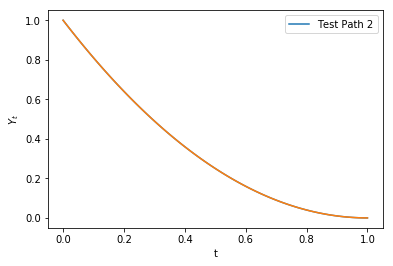

In [23]:
plt.plot(t, path_test2[1], label = "Test Path 2")
plt.legend()
# plt.title("Test Path 2")
plt.xlabel("t")
plt.ylabel(r"$Y_t$")

plt.savefig("./pics/geo_asian_test2.pdf")
plt.show()

In [ ]:
# comparison of true vs predicted solution of this path

plt.plot(t, true_solution(path_test2[1]), "m", label = "True")
plt.plot(t, solution_2[1], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test2[1]), "ko", label = "Terminal Value")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.title("Solution of Test Path 2")
plt.savefig("./pics/geo_asian_sol2.pdf")

## Test Another Path (Random Uniform)

In [ ]:
np.random.seed(5)

path_test4 = np.tile(np.random.uniform(1, 3, steps+1), (M,1))
pred_dict4 = {path: path_test4, time: time_feed}

In [ ]:
solution_4, space_derivative_4, time_derivative_4 = sess.run([solution, space_derivative, time_derivative], pred_dict4)

In [ ]:
loss_4 = sess.run(loss, pred_dict4)
loss_4

In [ ]:
plt.plot(t, path_test4[1], label = "Test Path 3")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$Y_t$")


plt.savefig("./pics/geo_asian_test3.pdf")
plt.show()

In [ ]:
# comparison of true vs predicted solution of this path

plt.plot(t, true_solution(path_test4[1]),"g", label = "True")
plt.plot(t, solution_4[1], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test4[1]), "ko", label = "Terminal Value")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.title("Solution of Test Path 3")
plt.savefig("./pics/geo_asian_sol3.pdf")

In [ ]:
plt.plot(t, path_test[2], "b", label = "Test Path 1")
plt.plot(t, path_test2[1],"m-.", label = "Test Path 2")
plt.plot(t, path_test4[1], "g:", label = "Test Path 3")

plt.xlabel("t")
plt.ylabel("$Y_t$")
plt.legend()
plt.savefig("./pics/geo_asian_paths.pdf")